In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [106]:
df = pd.read_csv("dataset_assurance.csv")
print(df.shape)
df.head()

(1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [107]:
df[df["bmi"] < 18.5]


,age,sex,bmi,children,smoker,region,charges
28,23,male,17.385,1,no,northwest,2775.19215
128,32,female,17.765,2,yes,northwest,32734.18630
172,18,male,15.960,0,no,northeast,1694.79640
198,51,female,18.050,0,no,northwest,9644.25250
232,19,female,17.800,0,no,southwest,1727.78500
250,18,male,17.290,2,yes,northeast,12829.45510
380,27,female,17.955,2,yes,northeast,15006.57945
410,19,male,17.480,0,no,northwest,1621.34020
412,26,female,17.195,2,yes,northeast,14455.64405
428,21,female,16.815,1,no,northeast,3167.45585


# 1. Vérifiez les informations manquantes et les doublons (outil : missingno).

valeurs nulles : 
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


<Axes: >

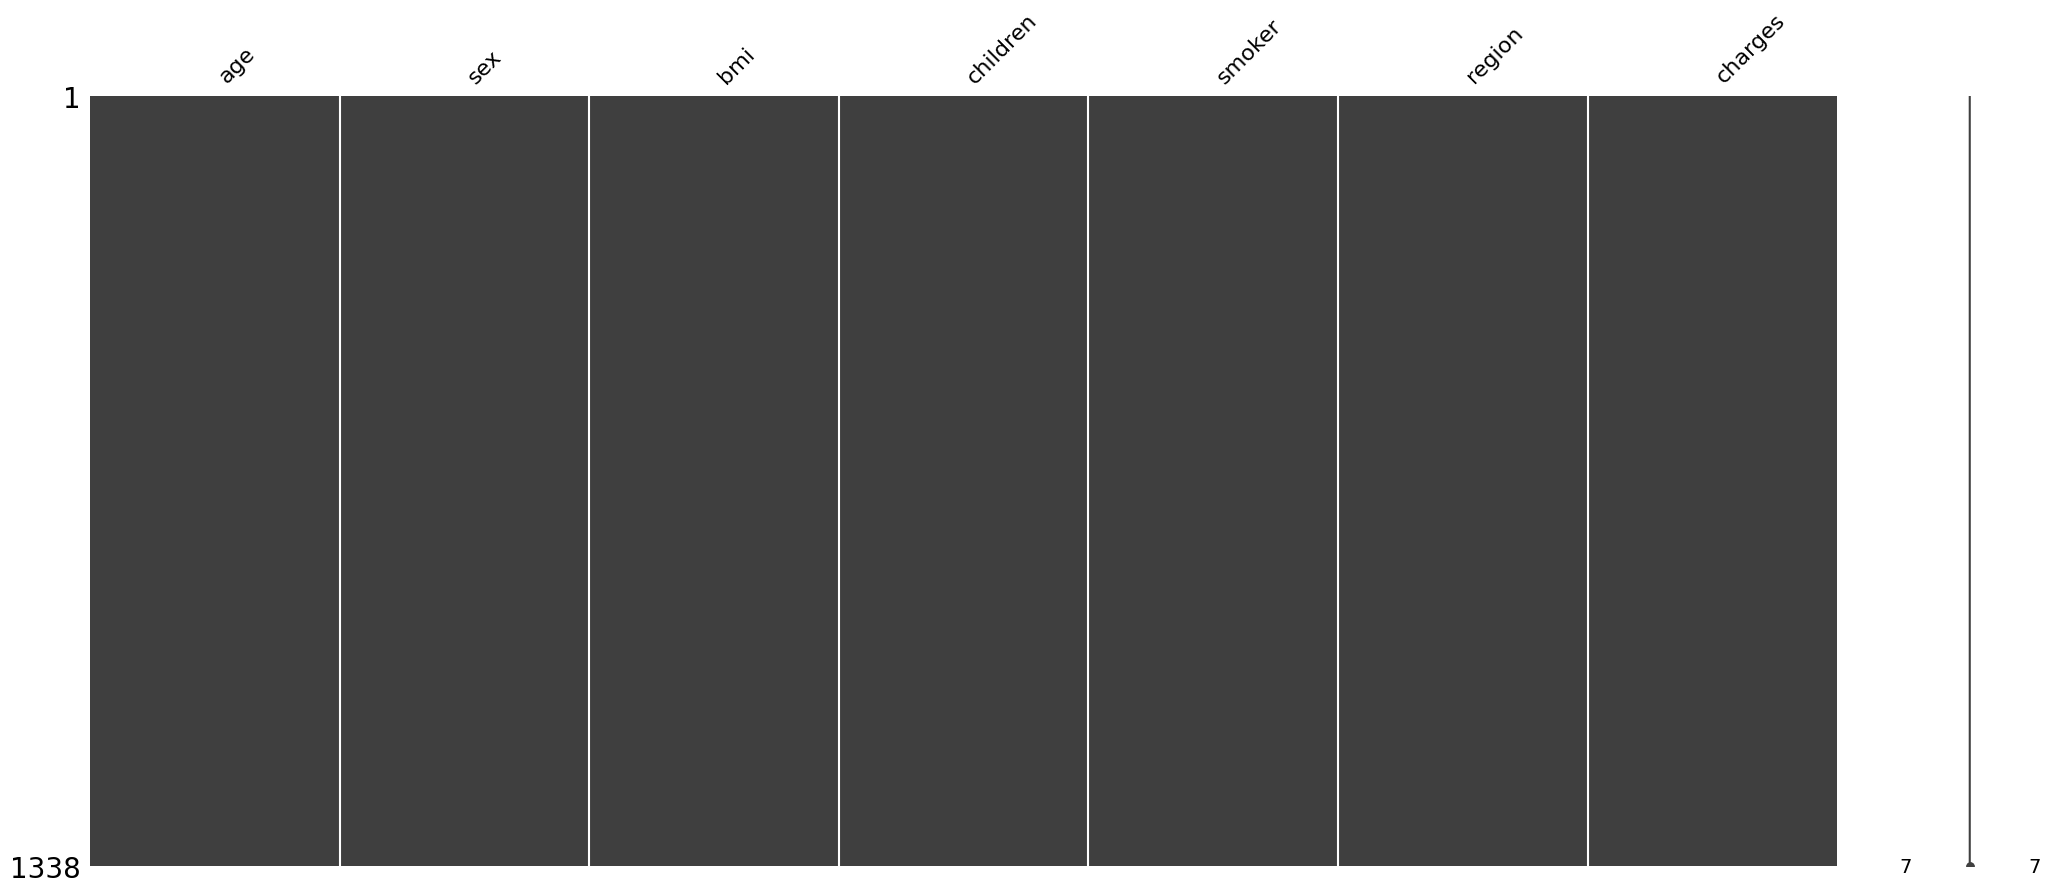

In [108]:
print("valeurs nulles : ")
print(df.isnull().sum())
msno.matrix(df)

suppression des valeurs dupliquées


<Axes: >

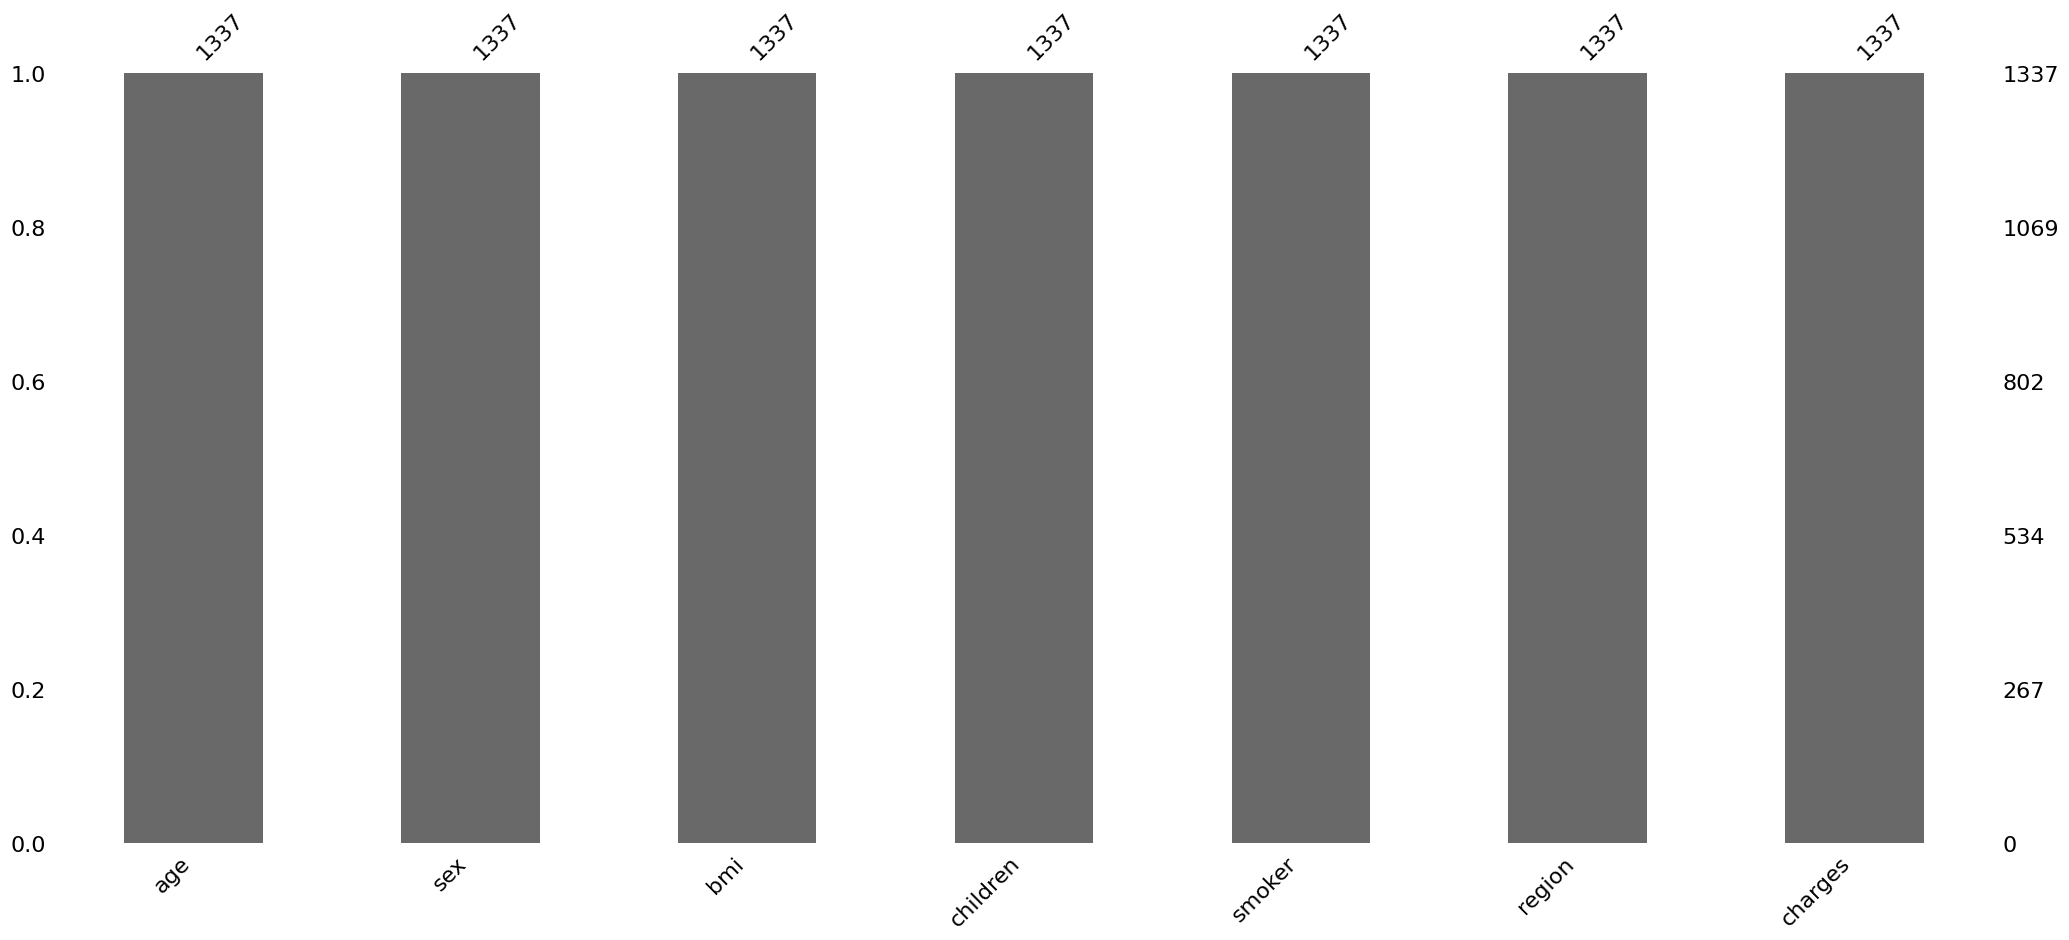

In [109]:
print("suppression des valeurs dupliquées")
msno.bar(df.drop_duplicates())

In [110]:
# print(df.shape)
print(df.drop_duplicates().shape)
print("lignes dupliquées : ")
df[df.duplicated()]

(1337, 7)
lignes dupliquées : 


,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


### suppression des lignes dupliquées

In [111]:
df.drop_duplicates(inplace=True)
df.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


In [112]:
df_copie = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


# 2. Détection des valeurs aberrantes.

In [113]:
# plt.figure(figsize=(10,5))
# plt.scatter(data=df, x="age", y="charges")

/tmp/ipykernel_1422034/1927756574.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df["age"]], labels=["age"])


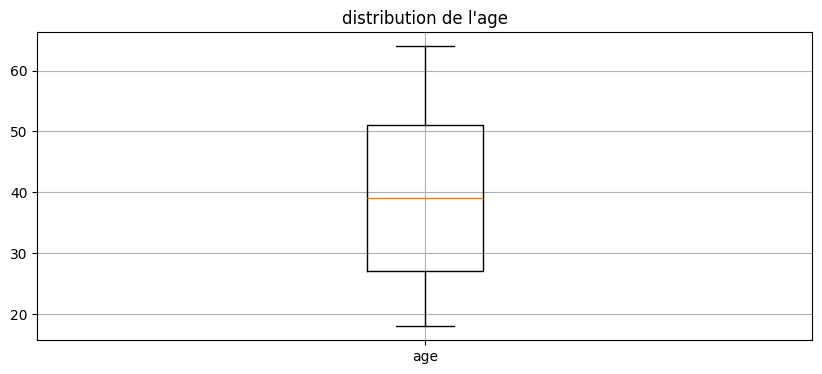

In [114]:
plt.figure(figsize=(10,4))
plt.boxplot([df["age"]], labels=["age"])
plt.title("distribution de l'age")
plt.grid()
plt.show()

/tmp/ipykernel_1422034/2706347072.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df["charges"]], labels=["charges"])


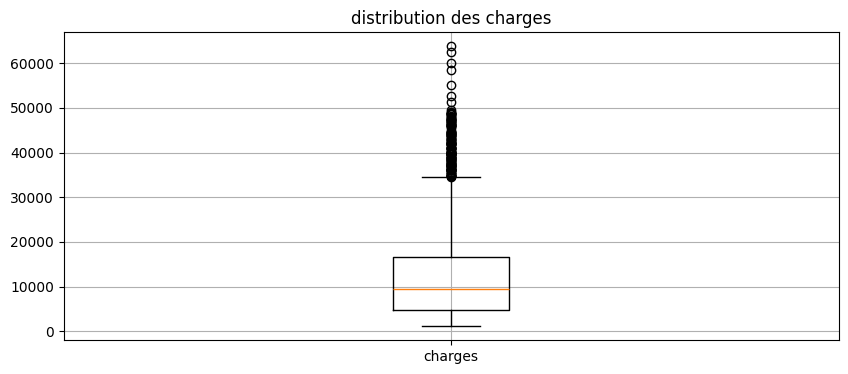

In [115]:
plt.figure(figsize=(10,4))
plt.boxplot([df["charges"]], labels=["charges"])
plt.title("distribution des charges")
plt.grid()
plt.show()

/tmp/ipykernel_1422034/3928439851.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df["bmi"], labels=["bmi"])


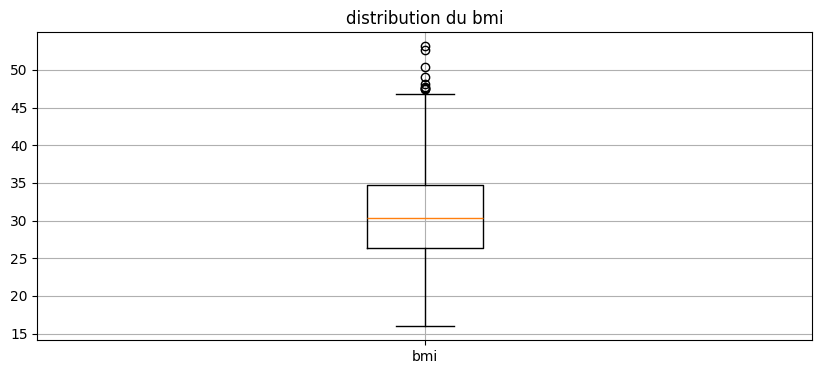

In [116]:
plt.figure(figsize=(10,4))
plt.boxplot(df["bmi"], labels=["bmi"])
plt.title("distribution du bmi")
plt.grid()
plt.show()

/tmp/ipykernel_1422034/2371879202.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(np.sqrt(df["bmi"]), labels=["bmi"])


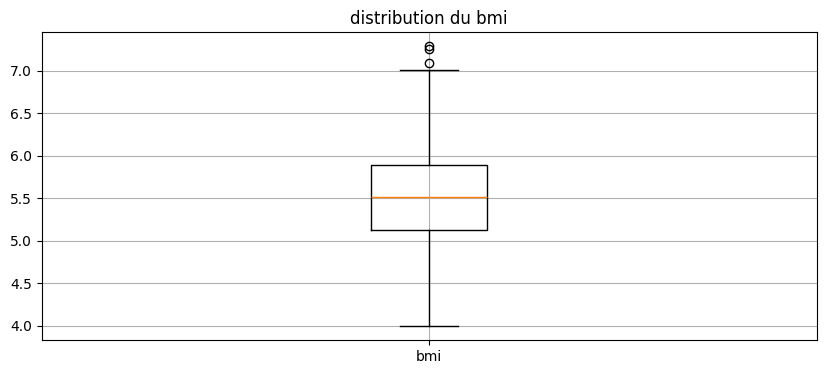

In [117]:
plt.figure(figsize=(10,4))
plt.boxplot(np.sqrt(df["bmi"]), labels=["bmi"])
plt.title("distribution du bmi")
plt.grid()
plt.show()

### min et max de charges et bmi :

In [118]:
df[df["charges"] == df["charges"].max()]

,age,sex,bmi,children,smoker,region,charges
543,54,female,47.41,0,yes,southeast,63770.42801


In [119]:
df[df["charges"] == df["charges"].min()]

,age,sex,bmi,children,smoker,region,charges
940,18,male,23.21,0,no,southeast,1121.8739


In [120]:
df[df["bmi"] == df["bmi"].max()]

,age,sex,bmi,children,smoker,region,charges
1317,18,male,53.13,0,no,southeast,1163.4627


In [121]:
df[df["bmi"] == df["bmi"].min()]

,age,sex,bmi,children,smoker,region,charges
172,18,male,15.96,0,no,northeast,1694.7964


### recherche des valeurs aberrantes

In [122]:
def recherche_valeurs_aberrantes(df, colonne) : 
    q1=df[colonne].quantile(0.25)
    q3=df[colonne].quantile(0.75)
    IQR=q3-q1
    limite_inf = q1 - 1.5*IQR
    limite_sup = q3 + 1.5*IQR
    valeurs_aberantes = df[(df[colonne]<limite_inf) | (df[colonne]>limite_sup)]
    return valeurs_aberantes, limite_inf, limite_sup


In [123]:
v_aberantes_charges = recherche_valeurs_aberrantes(df, "charges")[0]
print(f"nombre de lignes contenant des valeurs abérantes : {v_aberantes_charges.shape[0]}")
print(f"pourgentage de lignes contenant des valeurs abérantes : {round((v_aberantes_charges.shape[0] / df.shape[0]) * 100,2)} %")

nombre de lignes contenant des valeurs abérantes : 139
pourgentage de lignes contenant des valeurs abérantes : 10.4 %


In [124]:
v_aberantes_bmi, limite_inf_bmi, limite_sup_bmi = recherche_valeurs_aberrantes(df, "bmi")
print(f"nombre de lignes contenant des valeurs abérantes : {v_aberantes_bmi.shape[0]}")
print(f"pourgentage de lignes contenant des valeurs abérantes : {round((v_aberantes_bmi.shape[0] / df.shape[0]) * 100,2)} %")

nombre de lignes contenant des valeurs abérantes : 9
pourgentage de lignes contenant des valeurs abérantes : 0.67 %


 ### traitement des valeurs éberrantes :
<!-- 
- pour  bmi, on remplace les valeurs car pour une population ayant entre 18 et 64 ans et qui a un accés adéquat à la nourriture, un imc inférieur à 18.5 ou supérieur à 50 sont relativement rares
- pour charges, ne pas remplacer les valeurs aberrantes car les données sont des données réelles qui peuvent être impactées par d'autres facteurs ou d'autres variables qu'on n'a peut être pas dans notre dataset
  - on doit apprendre à notre modèle à prédire ces valeurs extrêmes --> -->


In [125]:
# df["bmi"] = df["bmi"].clip(lower=limite_inf_bmi, upper=limite_sup_bmi)
# df.describe()

In [126]:
# plt.figure(figsize=(10,4))
# # plt.boxplot([df["age"], df["bmi"], df["charges"]], labels=["age", "bmi", "charges"])
# plt.boxplot([df["bmi"]], labels=["bmi"])
# plt.title("distribution du bmi après traitemnt des valeurs aberrantes")
# plt.grid()
# plt.show()

In [127]:
# fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# sns.histplot(data=df, x="bmi", ax=axes[0], kde=True)
# axes[0].set_title("distribution bmi")

# sns.histplot(data=df, x="charges", ax=axes[1], kde=True)
# axes[1].set_title("distribution charges")

# sns.histplot(data=df, x="age", ax=axes[2], kde=True)
# axes[1].set_title("distribution age")
# plt.show()

In [128]:
# # Transformation logarithmique pour normaliser
# df['log_charges'] = np.log(df['charges'])

# # Tester la normalité des charges transformées
# stat, p_value = stats.normaltest(df['log_charges'])
# print("Test de normalité log_charges:")
# print(f"p-value: {p_value}")

# 3. Analyse univariée : Analysez chaque variable indépendamment.

### proportions des homes et des femmes, des fumeurs et non fumeurs, répartition des régions 

Text(0.5, 1.0, "répartition de l'échantillon dans les différetnes régions")

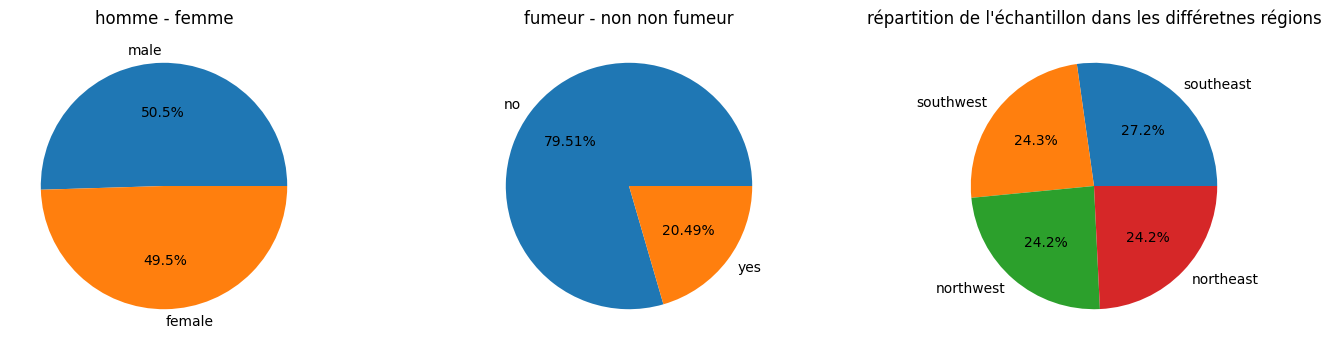

In [129]:
fig, axes = plt.subplots(1, 3, figsize=(17, 4))

axes[0].pie(df["sex"].value_counts(), labels=df["sex"].value_counts().index, autopct='%1.1f%%')
axes[0].set_title("homme - femme")

axes[1].pie(df["smoker"].value_counts(), labels=df["smoker"].value_counts().index, autopct='%1.2f%%')
axes[1].set_title("fumeur - non non fumeur")

axes[2].pie(df["region"].value_counts(), labels=df["region"].value_counts().index, autopct='%1.1f%%')
axes[2].set_title("répartition de l'échantillon dans les différetnes régions")


#### distribution des variables quantitatives

Text(0.5, 1.0, 'age')

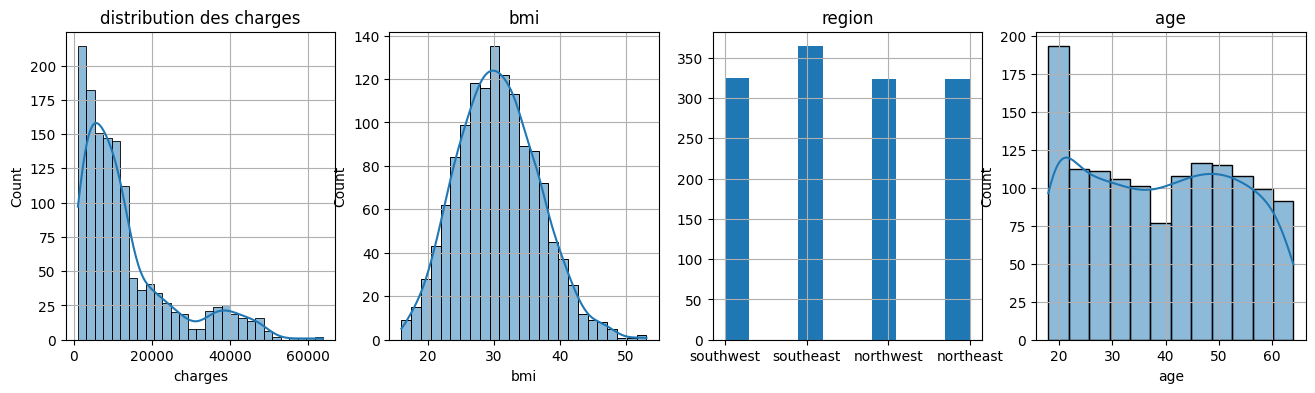

In [130]:

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

sns.histplot(data=df, x="charges", ax=axes[0], kde=True)
axes[0].grid()
axes[0].set_title("distribution des charges")

sns.histplot(data=df, x="bmi", ax=axes[1], kde=True)
axes[1].grid()
axes[1].set_title("bmi")

# sns.histplot(data=df, x="region", ax=axes[2], kde=True)
axes[2].hist(df["region"])
axes[2].grid()
axes[2].set_title("region")

sns.histplot(data=df, x='age', ax=axes[3], kde=True)
axes[3].grid()
axes[3].set_title("age")


# test de normalité :

    p-value < 0.05 : Résultat statistiquement significatif

        Dans le test de normalité : les données NE sont PAS normales

    p-value > 0.05 : Résultat non significatif

        Dans le test de normalité : les données SONT normales

In [131]:
from scipy import stats

stat, p_value = stats.normaltest(df["charges"])
print("Test de normalité charges:")
print(f"p-value: {p_value}")

Test de normalité charges:
p-value: 8.762608303862979e-74


In [132]:
stat, p_value = stats.normaltest(np.log(df["charges"]))
print("Test de normalité charges (après transformation logarithmique) :")
print(f"p-value: {p_value}")

Test de normalité charges (après transformation logarithmique) :
p-value: 4.745548606594116e-12


In [133]:
stat, p_value = stats.normaltest(df["bmi"])
print("Test de normalité bmi:")
print(f"p-value: {p_value}")

Test de normalité bmi:
p-value: 0.00015343822159821934


In [134]:
stat, p_value = stats.normaltest(df["age"])
print("Test de normalité age :")
print(f"p-value: {p_value}")

Test de normalité age :
p-value: 0.0


In [135]:
# from scipy.stats import boxcox
# boxcox(df['charges'])

# plt.hist(np.sqrt(df["bmi"]))
# plt.grid()
# plt.title("bmi")


# 4. Corrélation des variables : Étudiez les corrélations avec la variable cible.

In [136]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


bmi_cat
insuffisance pondérale     8852.200585
normal                    10075.622665
obésité I                 14452.444487
obésité II                17022.258883
obésité III               16784.615546
surpoids                  11109.701005
Name: charges, dtype: float64


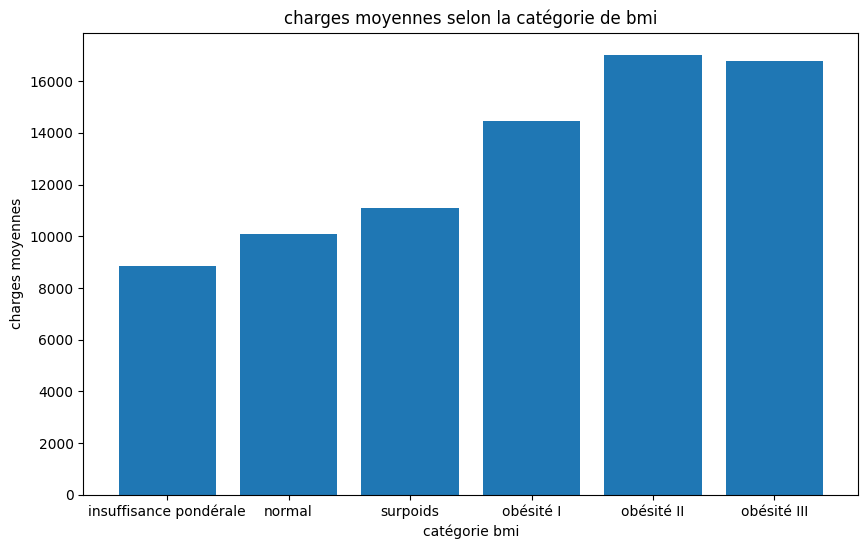

In [137]:
# catégories de bmi
def categorie_bmi(bmi):
    if bmi < 18.5 :
        return "insuffisance pondérale"
    elif bmi < 24.5:
        return "normal"
    elif bmi < 30:
        return "surpoids"
    elif bmi < 35:
        return "obésité I"
    elif bmi < 40:
        return "obésité II"
    else:
        return "obésité III"

df["bmi_cat"] = df["bmi"].apply(categorie_bmi)

moyennes_charges_bmi = df.groupby("bmi_cat")["charges"].mean()
print(moyennes_charges_bmi)
order = ["insuffisance pondérale", "normal", "surpoids", "obésité I", "obésité II", "obésité III"]
moyennes_charges_bmi = moyennes_charges_bmi.reindex(order)

# graphique
plt.figure(figsize=(10, 6))
plt.bar(moyennes_charges_bmi.index, moyennes_charges_bmi.values)
plt.xlabel("catégorie bmi")
plt.ylabel("charges moyennes")
plt.title("charges moyennes selon la catégorie de bmi")
plt.show()

# suppression colonne temporaire de cat imc
df.drop(["bmi_cat"], axis = 1, inplace = True)

age_cat
24 et moins     9037.953231
25-34          10352.392526
35-44          13134.168693
45-54          15853.927878
55 et plus     18513.276227
Name: charges, dtype: float64


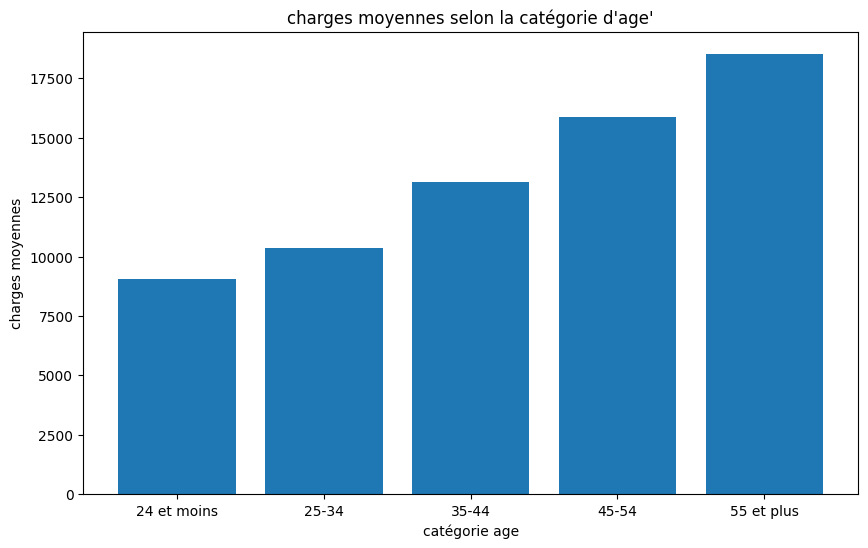

In [138]:
# catégories de bmi
def categorie_age(bmi) :
    if bmi < 25:
        return "24 et moins"
    elif bmi < 35:
        return "25-34"
    elif bmi < 45:
        return "35-44"
    elif bmi < 55:
        return "45-54"
    else:
        return "55 et plus"

df["age_cat"] = df["age"].apply(categorie_age)

moyenne_charges_cat_age = df.groupby("age_cat")["charges"].mean()
print(moyenne_charges_cat_age)
order = ["24 et moins", "25-34", "35-44", "45-54", "55 et plus"]
moyenne_charges_cat_age = moyenne_charges_cat_age.reindex(order)

# graphique
plt.figure(figsize=(10, 6))
plt.bar(moyenne_charges_cat_age.index, moyenne_charges_cat_age.values)
plt.xlabel("catégorie age")
plt.ylabel("charges moyennes")
plt.title("charges moyennes selon la catégorie d'age'")
plt.show()

# suppression colonne temporaire de cat age
df.drop(["age_cat"], axis = 1, inplace = True)

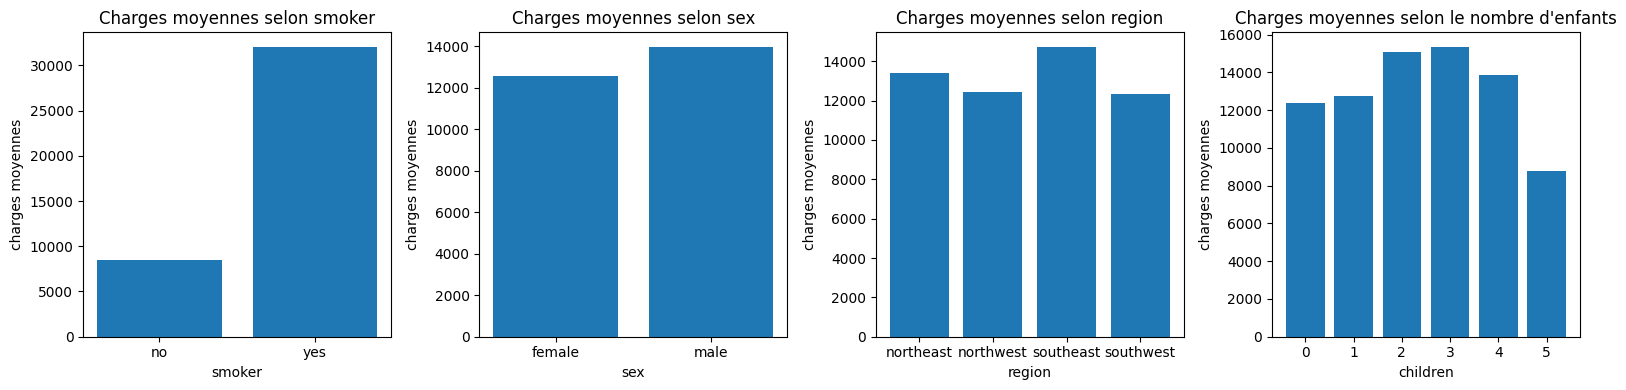

In [139]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))


# Smoker
smoker_means = df.groupby('smoker')['charges'].mean()
axes[0].bar(smoker_means.index, smoker_means.values)
axes[0].set_xlabel("smoker")
axes[0].set_ylabel("charges moyennes")
axes[0].set_title("Charges moyennes selon smoker")

# Sex
sex_means = df.groupby('sex')['charges'].mean()
axes[1].bar(sex_means.index, sex_means.values)
axes[1].set_xlabel("sex")
axes[1].set_ylabel("charges moyennes")
axes[1].set_title("Charges moyennes selon sex")

# region
sex_means = df.groupby("region")["charges"].mean()
axes[2].bar(sex_means.index, sex_means.values)
axes[2].set_xlabel("region")
axes[2].set_ylabel("charges moyennes")
axes[2].set_title("Charges moyennes selon region")

# enfants
sex_means = df.groupby("children")["charges"].mean()
axes[3].bar(sex_means.index, sex_means.values)
axes[3].set_xlabel("children")
axes[3].set_ylabel("charges moyennes")
axes[3].set_title("Charges moyennes selon le nombre d'enfants")

# bmi



plt.tight_layout()
plt.show()

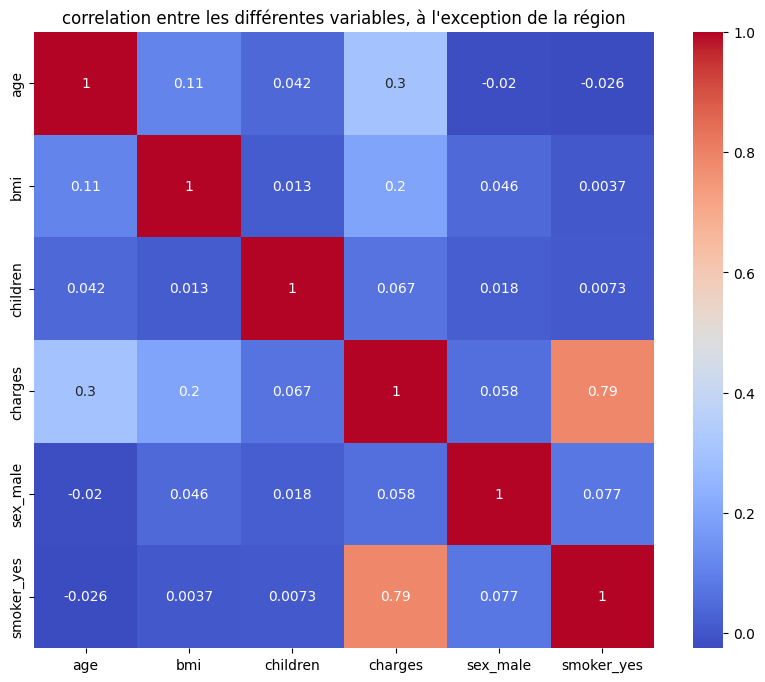

,age,bmi,children,region,charges,sex_male,smoker_yes
0,19,27.900,0,southwest,16884.92400,False,True
1,18,33.770,1,southeast,1725.55230,True,False
2,28,33.000,3,southeast,4449.46200,True,False
3,33,22.705,0,northwest,21984.47061,True,False
4,32,28.880,0,northwest,3866.85520,True,False
...,...,...,...,...,...,...,...
1333,50,30.970,3,northwest,10600.54830,True,False
1334,18,31.920,0,northeast,2205.98080,False,False
1335,18,36.850,0,southeast,1629.83350,False,False
1336,21,25.800,0,southwest,2007.94500,False,False


In [140]:
df = pd.get_dummies(df, columns=["sex", "smoker"], drop_first=True)
correlation_matrix = df.drop("region", axis=1).corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("correlation entre les différentes variables, à l'exception de la région")
plt.show()
df

In [141]:
df.head()
df.isna().sum()

age           0
bmi           0
children      0
region        0
charges       0
sex_male      0
smoker_yes    0
dtype: int64

In [142]:
encoder1 = LabelEncoder()
encoder2 = OneHotEncoder(sparse_output=False)

categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
encoded_df = encoder2.fit_transform(df[categorical_columns])
one_hot_df = pd.DataFrame(encoded_df, columns=encoder2.get_feature_names_out(categorical_columns), index=df.index)

# suppression des colonnes non numériques
df = df.drop(categorical_columns, axis = 1)

df_final = pd.concat([df, one_hot_df], axis=1)
df_final.isna().sum()


age                 0
bmi                 0
children            0
charges             0
sex_male            0
smoker_yes          0
region_northeast    0
region_northwest    0
region_southeast    0
region_southwest    0
dtype: int64

In [143]:
df_final.to_csv("df_final_assurance.csv", header=True, index=False, encoding="utf-8")

In [144]:
# sns.pairplot(df_final)

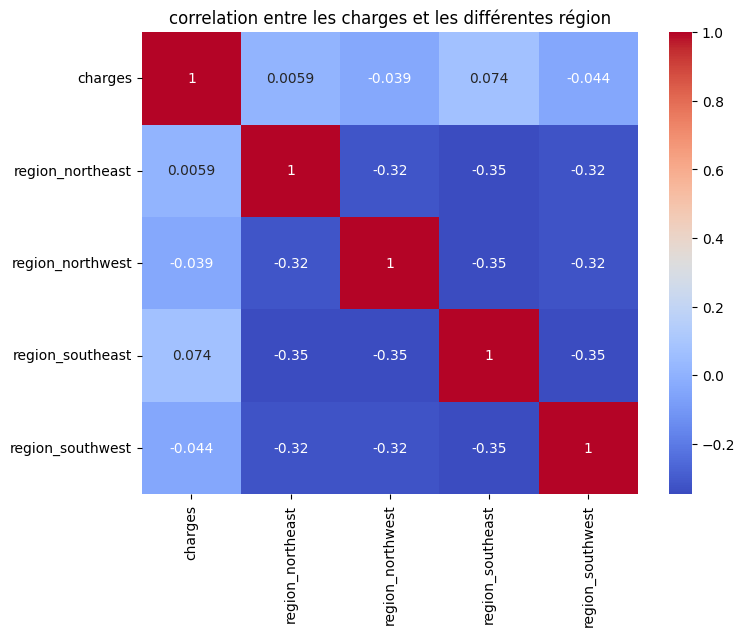

In [145]:
correlation_matrix = df_final[["charges", "region_northeast", "region_northwest", "region_southeast", "region_southwest" ]].corr()
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("correlation entre les charges et les différentes région")
plt.show()


# 5. Analyse bivariée : Exemple : interaction entre sexe et fumeur.

In [146]:
df_final.head(1)

,age,bmi,children,charges,sex_male,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.9,0,16884.924,False,True,0.0,0.0,0.0,1.0


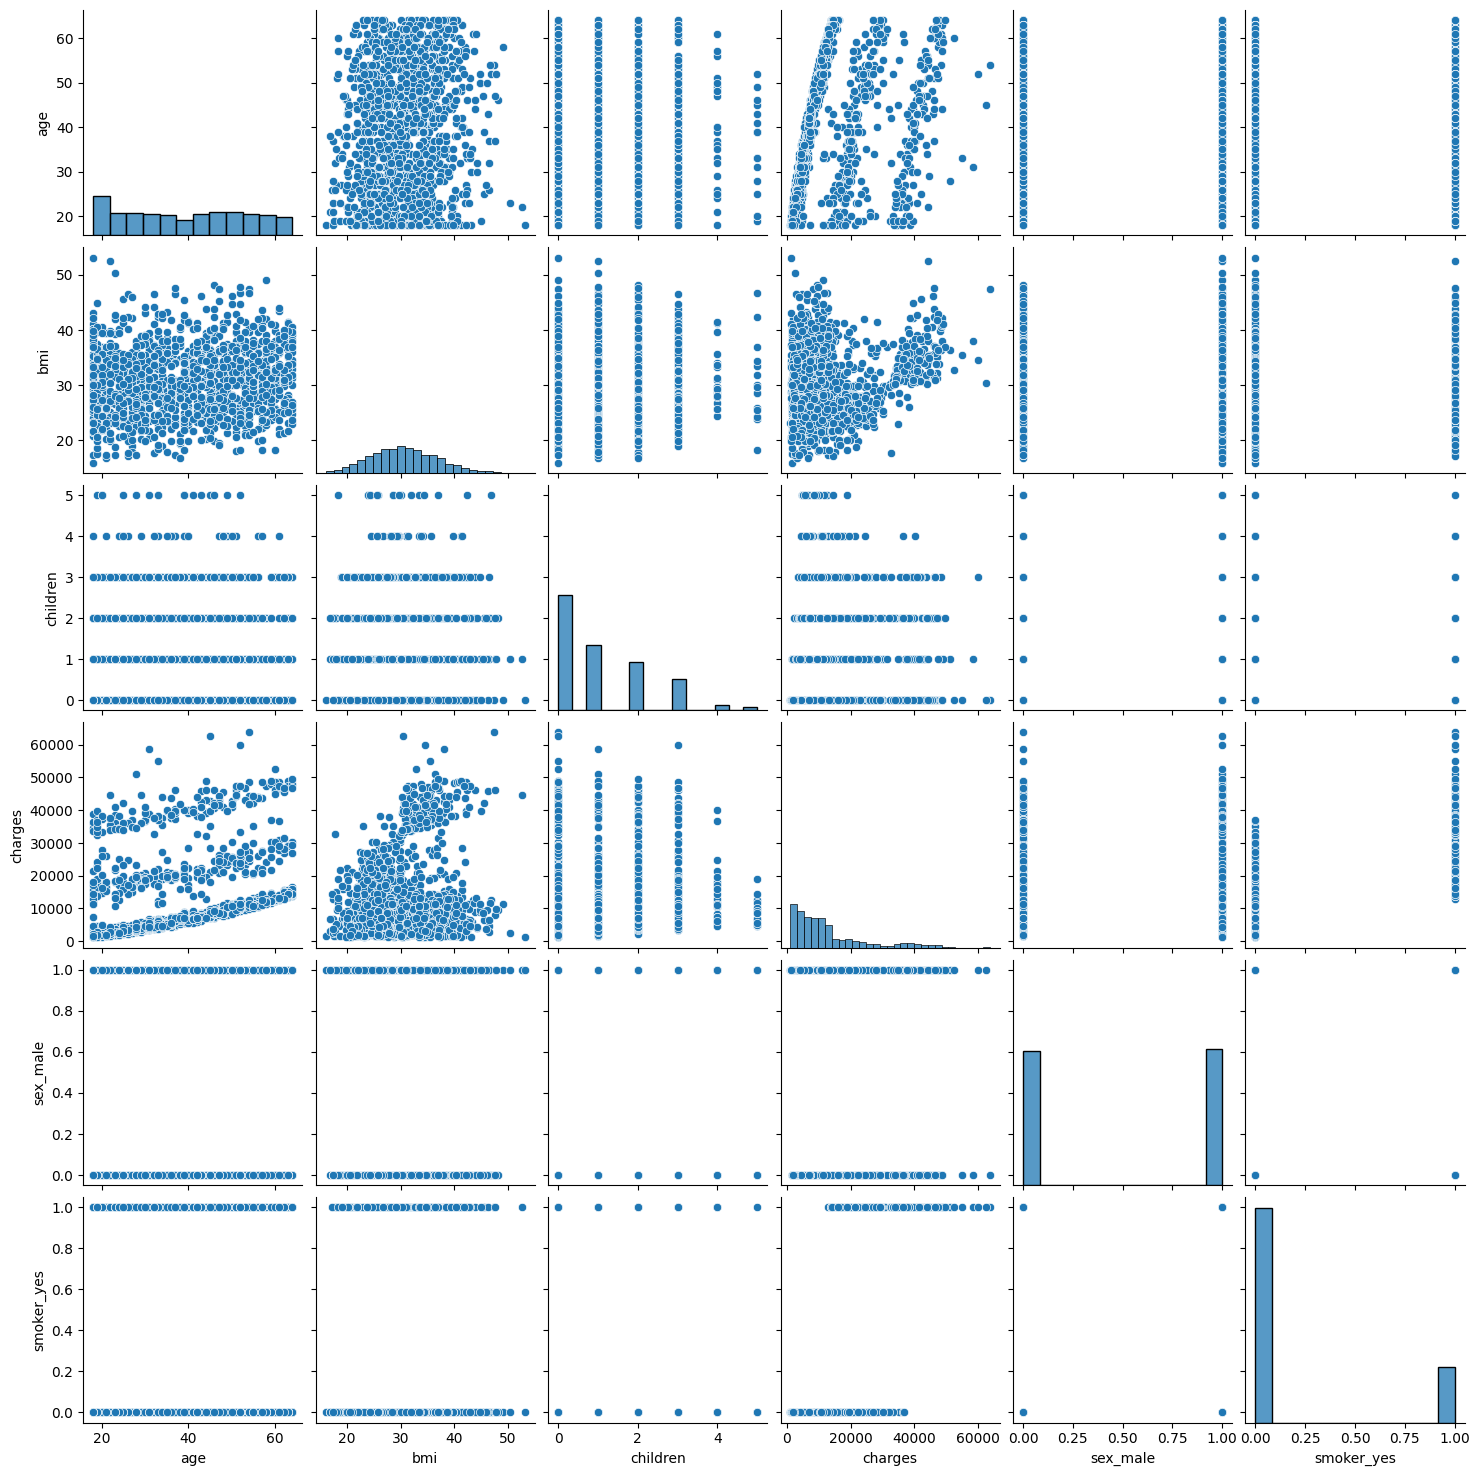

In [147]:
# df = pd.get_dummies(df, columns=["sex", "smoker"], drop_first=True)
sns.pairplot(df_final.drop(["region_northeast", "region_northwest", "region_southeast", "region_southwest"], axis=1))

In [148]:
df = df_copie.copy()
table1 = pd.crosstab(df["sex"], df["smoker"])
print("taux d'hommes et de femmes fumeurs et non fumeurs")
table1



taux d'hommes et de femmes fumeurs et non fumeurs


smoker,no,yes
sex,,
female,547,115
male,516,159


In [149]:
# charges_moyennes_sex_smoker = df.groupby(["sex", "smoker"])["charges"].mean().reset_index()
charges_moyennes_sex_smoker = df.groupby(["sex", "smoker"])["charges"].mean().unstack()
charges_moyennes_sex_smoker

smoker,no,yes
sex,,
female,8762.297300,30678.996276
male,8099.700161,33042.005975


<Figure size 1000x600 with 0 Axes>

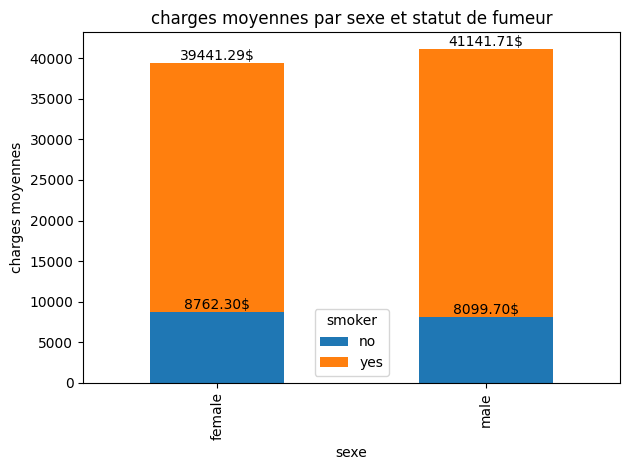

In [150]:
plt.figure(figsize=(10,6))
ax = charges_moyennes_sex_smoker.plot(kind="bar", stacked=True)
plt.title("charges moyennes par sexe et statut de fumeur")
plt.xlabel("sexe")
plt.ylabel("charges moyennes")
for i in ax.containers:
    ax.bar_label(i, fmt="%.2f$")
plt.tight_layout()
plt.show()

In [151]:
table2 = pd.crosstab(df["sex"], df["region"])
print("nombre d'hommes et de femmes par région")
table2

nombre d'hommes et de femmes par région


region,northeast,northwest,southeast,southwest
sex,,,,
female,161,164,175,162
male,163,160,189,163


In [152]:
table3 = pd.crosstab(df["smoker"], df["region"])
print("nombre de fumeurs par région")
table3

nombre de fumeurs par région


region,northeast,northwest,southeast,southwest
smoker,,,,
no,257,266,273,267
yes,67,58,91,58


In [153]:
df.groupby(['sex', 'smoker'])['charges'].describe()

count          mean           std         min           25%  \
sex    smoker                                                                
female no      547.0   8762.297300   6060.775970   1607.5101   4265.599100   
       yes     115.0  30678.996276  11907.536381  13844.5060  19696.432100   
male   no      516.0   8099.700161   5907.000174   1121.8739   3684.907500   
       yes     159.0  33042.005975  11202.670862  12829.4551  21241.526875   

                        50%          75%          max  
sex    smoker                                          
female no       7639.417450  11786.16660  36910.60803  
       yes     28950.469200  40918.31450  63770.42801  
male   no       6986.101975  10960.85900  32108.66282  
       yes     36085.219000  41797.58905  62592.87309

In [154]:
df.groupby(['sex', 'region'])['charges'].describe()

count          mean           std         min          25%  \
sex    region                                                                  
female northeast  161.0  12953.203151  10591.929980  2196.47320  5458.046450   
       northwest  164.0  12479.870397  10596.572843  2117.33885  4918.789338   
       southeast  175.0  13499.669243  12587.261506  1607.51010  4382.836600   
       southwest  162.0  11274.411264  10453.660658  1727.78500  4895.811250   
male   northeast  163.0  13854.005374  11890.942381  1694.79640  4880.990000   
       northwest  160.0  12421.085552  11574.543615  1621.34020  4449.280962   
       southeast  189.0  15879.617173  15083.360816  1121.87390  4463.205100   
       southwest  163.0  13412.883576  12499.550025  1241.56500  4658.699500   

                           50%           75%          max  
sex    region                                              
female northeast  10197.772200  15359.104500  58571.07448  
       northwest   9614.072900  14492.722725  55135.40209  
       southeast   8582.302300  18220.806295  63770.42801  
       southwest   8530.837000  12642.990500  48824.45000  
male   northeast   9957.721600  18276.474375  48549.17835  
       northwest   8420.766175  15976.212950  60021.39897  
       southeast   9504.310300  21978.676900  62592.87309  
       southwest   9391.346000  17119.976000  52590.82939

In [155]:
df.groupby(['smoker', 'region'])['charges'].describe()


count          mean           std         min           25%  \
smoker region                                                                   
no     northeast  257.0   9165.531672   6157.196439   1694.7964   4438.263400   
       northwest  266.0   8582.467101   6125.331366   1621.3402   4201.807987   
       southeast  273.0   8032.216309   6137.329758   1121.8739   3471.409600   
       southwest  267.0   8019.284513   5489.514421   1241.5650   3947.026500   
yes    northeast   67.0  29673.536473  11589.559770  12829.4551  19881.400425   
       northwest   58.0  30192.003182  11413.827702  14711.7438  20834.130337   
       southeast   91.0  34844.996824  11324.766536  16577.7795  23155.105450   
       southwest   58.0  32269.063494  11270.279593  13844.5060  20396.042022   

                           50%           75%          max  
smoker region                                              
no     northeast   8342.908750  11938.255950  32108.66282  
       northwest   7259.232050  11355.802575  33471.97189  
       southeast   6652.528800  10982.501300  36580.28216  
       southwest   7348.142000  11017.990500  36910.60803  
yes    northeast  28101.333050  39576.950850  58571.07448  
       northwest  27488.996475  39918.948975  60021.39897  
       southeast  37484.449300  43391.859400  63770.42801  
       southwest  35165.256500  39809.292750  52590.82939